# Object Recognition using Caffe and Selective Search

In this tutorial, we'll walk through a relatively straightforward approach to object recognition using powerful pre-trained caffe networks and selection sort. This is definitely not the most efficient approach to object recognition, but is still relatively fast and quite intuitive.

First import various libraries. This project requires dlib and openCV.

In [1]:
from skimage import io
import skimage.data
from skimage import img_as_float
import selectivesearch
import pdb
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import dlib
import cv2

To load caffe, you need to add the caffe module root path. Make sure to adjust the caffe root path based on your setup! Many of the following steps utilize the root path.

In [2]:
caffe_root = '/usr/local/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe

Load the labels file. CaffeNet has 1000 output classes, so this text file allows you to map the net output index to an object. We'll try to identify two different kinds of objects...cats (because cats are hilarious) and baseball players (because sports).

For cats, CaffeNet recognizes many different breeds of cats as well as other animals that are closely related (such as cougars, lions, and cheetahs). When we run the classifier, we'll consider all these labels as they are all generally in the "cat" family. That will help us get better results, rather than looking narrowly at a specific breed of cat.

For baseball players, there is just one label. So this is straightforward.

To define the label indices, open up the synset_words.txt file and look for the row corresponding to the object you're trying to detect (the file is 1000 rows long, each row corresponding to the classifier index of the object).

In [3]:
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
#load the labels file if you don't have it yet
if not os.path.exists(labels_file):
    print 'downloading model labels...'
    os.system(caffe_root + 'data/ilsvrc12/get_ilsvrc_aux.sh')

#load the labels text file
net_labels = np.loadtxt(labels_file, str, delimiter='\t')

#cat label indices
cat_inds = range(277,295)

#basketball label index. note that there is only one index, but we'll put it into an array
#to make things easier later on
baseball_inds = np.array([981])

Load CaffeNet and configure the transformer. The transformer is basically an object that is used to preprocess each new image so that it's in the format defined in deploy.prototxt. For CaffeNet, it expects the image to be in BGR format, as the shape (3, width, height), mean image subtracted, and in the scale [0,255] (we'll assume all input images are in this format). The transformer takes care of all these steps, although you could just as well do it manually without the use of the transformer at all. However, using the transformer on a GPU-based system will likely be faster.

In addition to the above requirements, CaffeNet requires the input image to be of dimension 227x227. The reshape layer handles this requirement.

In [4]:
#batch size for net (defined in deploy.prototxt as the shape input_param in the data layer)
batch_size = 10

#set caffe to CPU mode (you can switch to GPU mode if you have a GPU)
caffe.set_mode_cpu()

#define the directories for the model definition and model weights
model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
model_path = caffe_root + 'models/bvlc_reference_caffenet/'

#download the actual CaffeNet model file if it doesn't exist (this is ~240MB so it may take a while)
if not os.path.exists(model_weights):
    print 'downloading CaffeNet model...\n'
    sys.stdout.flush()
    os.system('python ' + caffe_root + 'scripts/download_model_binary.py ' + caffe_root + 'models/bvlc_reference_caffenet/')

#create a net object
net = caffe.Net(model_def,      #defines the structure of the model
                model_weights,  #contains the trained weights
                caffe.TEST)     #use test mode (e.g., don't perform dropout)

#load the mean image for subtraction and get the average B,R,G pixel values
mean_img = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mean_img_avg = np.zeros(3)
mean_img_avg[0] = np.mean(mean_img[0,:,:].ravel())
mean_img_avg[1] = np.mean(mean_img[1,:,:].ravel())
mean_img_avg[2] = np.mean(mean_img[2,:,:].ravel())

print ('image mean: B:%f, G:%f, R:%f') % (mean_img_avg[0], mean_img_avg[1], mean_img_avg[2])

#now define the transformer for input data. the layer name for input data (first layer) is "data"
#take a look at the deploy.prototxt for full details
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) #assign the layer name as "data"
transformer.set_transpose('data', (2,0,1)) #transform an image from (width,height,3) to (3,width,height)
transformer.set_mean('data', mean_img_avg) #subtract the mean in each channel
transformer.set_channel_swap('data', (2,1,0)) #swap channels from RGB to BGR. openCV's imread function already does this for us

#resize the images as defined in deploy.prototxt (227x227)
net.blobs['data'].reshape(batch_size,   #batch size (number of images to process in one go)
                          3,            #3-channel (BGR) images
                          227, 227)     #image size is 227x227

image mean: B:104.006988, G:116.668768, R:122.678914


Let's take a look at the net structure.

In [5]:
#for each layer, print the shape of the output
#values are in the following order: batch_size, channel_dim, height, width
print 'net output shape:'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

#for each layer, print the parameters
#values are in the following order: output_channels, input_channels, filter_height, filter_width
#note that these don't include stride or zero padding parameters, as they are optional inputs
print '\nnet parameters:'
for layer_name, param in net.params.iteritems(): 
    print layer_name + '\t' + str(param[0].data.shape)

net output shape:
data	(10, 3, 227, 227)
conv1	(10, 96, 55, 55)
pool1	(10, 96, 27, 27)
norm1	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
norm2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
conv4	(10, 384, 13, 13)
conv5	(10, 256, 13, 13)
pool5	(10, 256, 6, 6)
fc6	(10, 4096)
fc7	(10, 4096)
fc8	(10, 1000)
prob	(10, 1000)

net parameters:
conv1	(96, 3, 11, 11)
conv2	(256, 48, 5, 5)
conv3	(384, 256, 3, 3)
conv4	(384, 192, 3, 3)
conv5	(256, 192, 3, 3)
fc6	(4096, 9216)
fc7	(4096, 4096)
fc8	(1000, 4096)


Now define a function to run selective search on each new image, to provide numerous region proposals. Before running the selective search algorithm, resize the input image such that the width is 480 (and adjust the height proportionally to maintain the aspect ratio). The reason to do this is so that the selective search algorithm returns roughly 1000 to 2000 results. If the image is too large or too small, it will return either too many or too few regions of interest.

Note that we will discard many regions returned by selective search. Any region that is less than 15 pixels in either width or height, or is not "square-ish" (ie ratio of width to height is greater than 1.75) is not considered for classification. These parameters should probably be adjusted based on the dimensions of the object you are trying to classify.

In [6]:
def selective_search(img):
    #run selective search to get the region proposals. locations of candidate objects will be saved into the "rects" 
    #array. loop through each result in rects and add it to a set, which by definition, cannot have multiples. so this 
    #step gets rid of any potential duplicate regions, if there in fact are any
    print 'running selective search...'
    
    #before running the selective search, resize the image to a width of 480 and a proportional height. for increasing
    #image size, use INTER_CUBIC interpolation. for decreasing size, use INTER_AREA
    height,width,dim = np.shape(img)
    new_width = 480
    ratio = new_width/float(width)
    new_height = int(height*ratio)
    if ratio > 0:
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    #do the actual selective search now
    rects = []
    dlib.find_candidate_object_locations(img, rects, min_size=300)
    print ('total number of regions found: %i') % (len(rects))

    #filter out duplicates and unreasonable regions
    candidates = set()
    for k, rect in enumerate(rects):
        left, top, right, bottom = rect.left(), rect.top(), rect.right(), rect.bottom()

        #x is defined as the x coordinate of the bottom left corner
        #y is defined as the y coordinate of the top right corner
        #for definitions of left, top, right, bottom:
        #http://stackoverflow.com/questions/22589322/what-does-top-left-right-and-bottom-mean-in-android-rect-object
        x, y, width, height = left, top, (right-left), (bottom-top)
        
        #don't add any regions that fit these criteria
        if width < 15 or height < 15 or width / float(height) > 1.75 or height / float(width) > 1.75:
            continue

        candidates.add((x, y, width, height, left, top, right, bottom)) 
        #io.imsave(str(k) + '.jpg', img[y:y+height, x:x+width, :])  #if you want to visualize the regions, uncomment this line

    #cast the set back to a list (easier to work with). the list is basically an array of tuples, where each tuple is:
    #x, y, width, height, left, top, right, bottom
    candidates = list(candidates)
    print ('number of valid regions found: %i') % (len(candidates))
    
    return (img, candidates)

Next, define a function to classify each of the regions generated by the selective search algorithm in the previous function. First, each region is extracted from the image and transformed according to the specifications of the transformer defined earlier. 

After all regions have been processed, we run forward propogation on batch_size images at a time (10, in this case). Each time we run forward propogation, caffe returns a dictionary of probability values that is batch_size rows by 1000 columns (because CaffeNet has 1000 classes). We store all the results in the "net_output" array for later analysis.

In [7]:
def classify_each_region(img, candidates):
    #loop over all the regions and transform them
    #the number of batches is defined as the number of candidate regions divided by the batch size, rounded up to the
    #nearest batch size
    num_batches = int(np.ceil(len(candidates)/float(batch_size)))
    
    print 'transforming image regions...'
    transformed_imgs = np.zeros(shape=(num_batches*batch_size, 3, 227, 227))
    for patch_count, (x, y, width, height, left, top, right, bottom) in enumerate(candidates):
        patch = img[y:y+height, x:x+width, :]/1. #divide by 1.0 to make sure this is a float
        #io.imsave(str(patch_count) + '.jpg', patch) #uncomment to visualize the different regions
        
        #do the actual preprocessing
        transformed_img = transformer.preprocess('data', patch)
        transformed_imgs[patch_count] = transformed_img

    #copy the image data into the memory allocated for the net, batch_size at a time
    print 'running forward prop...'
    net_output = np.zeros(shape=(num_batches*batch_size, 1000))
    for i in range(0,num_batches):
        #this funny notation basically just copies the entire batch_size set of images into the net's memory
        net.blobs['data'].data[...] = transformed_imgs[i*batch_size:batch_size*(i+1)]
        
        #do the classification
        net_output_dict = net.forward()
        
        #extract the array of probabilities out of the dictionary and put them into the "net_output" array
        net_output[i*batch_size:batch_size*(i+1),:] = net_output_dict['prob']
    #pickle.dump(net_output, open('net_output.p', 'wb'))  #if you want to save the net output uncomment this line

    #the classifier will return an array of 1000 probabilties for each region. take the highest probability from
    #each region and print its corresponding probability and label. this gives interesting insights into what the
    #classifier is seeing in the image...commented out for now to keep the output cleaner
    PRINT_ALL_RESULTS = False
    if PRINT_ALL_RESULTS:
        for val in net_output: 
            print net_labels[np.argmax(val)], val[np.argmax(val)]

    return net_output

Now we define the function to do bounding box analysis. This function takes as input all regions that were proposed by the selective search algorithm and their corresponding classifier probabilities. Recall that each candidate region now has a corresponding classifier output with 1000 different probabilities.  

In the first part of the bounding box analysis, we loop through each region's classifier output and find the label corresponding to the highest probability output for that region. If the probability is at least 0.4, and the label associated with that highest probability value is either cat or baseball, we mark this as a positive region. There will most likely be many positive regions in this step, many of which are partially overlapping and partially encompassing the object of interest. We will store all positive regions in this step, and accept that there may be some poor results or false positives.

In the next step, we intelligently combine the many overlapping positive regions in a way that will minimize the effect of false positive regions, and put a tight boundary on the object of interest. This is a fairly complex step that is easily handled by the openCV function groupRectangles:  
http://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html#grouprectangles

Essentially, the groupRectangles function extracts features from each positive region (examples include height, width, centroid, etc.) and uses clustering of these features to determine the optimal boundary box parameters. This approach assumes that the majority of the positive regions are generally in the right area. The largest cluster is used to compute the most confident bounding box. If multiple bounding boxes are required, the largest N clusters are used.

To increase generality, this function accepts a num_objects parameter. If your image has say, 2 cats, pass num_objects=2 to create two bounding boxes. 

The final optimal bounding box is plotted in red around the object. To view all the positive regions that were used to determine the final bounding box, pass plot_all_positive_regions=True.

In [8]:
#input paramaters:
#img: the image to detect an object from
#candidates: the region proposals from selective search
#net_output: the class probabilities associated with each region proposal 
#label_indices: the indices corresponding to the object of interest, based on synset_words.txt
#filename: the filename of this image, to save the final bounding box result
#num_objects: the number of objects of interest in this particular image (default=1)
#plot_all_positive_regions: defines whether or not to plot all positive regions found by the classifier (default=True)
def bounding_box_analysis(img, candidates, net_output, label_indices, filename, num_objects=1, plot_all_positive_regions=True):
    print 'running bounding box analysis...'
    
    min_prob = 0.4
    patch_count = 0
    
    #store positive regions in opencv_candidates, and store their corresponding labels and probabilities
    opencv_candidates = [] 
    labels = []
    probs = []
    
    #define the plot for showing the bounding box results. rotate the image back to RGB to make the plot
    #look natural
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    #img = np.roll(img, 1, axis=-1)
    
    #loop through each region
    for patch_count, (x, y, width, height, left, top, right, bottom) in enumerate(candidates):
        #grab the label index corresponding to the highest probability, and the probability value
        prob = net_output[patch_count]
        label_ind = np.argmax(prob)
        prob = prob[label_ind]

        #if the probability is higher than min_prob and is a valid index, store it as a positive region
        if (prob > min_prob) and (label_ind in label_indices):
            if plot_all_positive_regions:
                #extract a patch and plot it
                patch = img[y:y+height, x:x+width, :]
                rect = mpatches.Rectangle((x, y), width, height, fill=False, edgecolor='green', linewidth=1)
                t = ax.add_patch(rect)

            #also add to the list. in opencv rect is defined as Rect(int x, int y, int width, int height) 
            #where x, y correspond to the x and y coordinates of the top left corner. define candidates in 
            #this format
            opencv_candidates.extend([[x, y, width, height]])

            #keep a list with the label and corresponding probability
            labels.extend([net_labels[label_ind]])
            probs.extend([prob])

    #now that all regions have been assessed, check if there were any valid candidates. if not, then return
    #this is a very possible scenario, as the image may not have what we're looking for
    if len(labels) == 0:
        print 'no valid candidates found'
        #show the final image
        ax.imshow(img)
        plt.axis('off')
        plt.show()
        return None

    #define the label of the object for plotting later on, corresponding to the highest probability result among
    #all positive regions
    best_label = labels[np.argmax(probs)]
    best_label = ' '.join(best_label.split(' ')[1:])

    #use opencv to cluster together similar bounding boxes. groupThreshold is defined as the minimum number of 
    #rectangles in a cluster minus one, to consider this a valid cluster. ideally this would be set to 2 or 3.
    #in general, a higher value value of groupThreshold will yield tighter bounding boxes. however, setting it
    #too high could result in no bounding boxes found. currently set to 0. epsilon is a parameter that determines 
    #how clustered the data is. for epsilon=0, there are no clusters (ie, K=N for k nearest neighbors). for 
    #epsilon->inf, there is only one cluster (ie K = 1). default value is 0.2
    groupThreshold = 2
    epsilon = 0.3
    rects, weights = cv2.groupRectangles(opencv_candidates,groupThreshold,epsilon)

    #if there aren't any rectangles found, just return
    if len(rects) == 0:
        print 'no bounding box found'
        #show the final image
        ax.imshow(img)
        plt.axis('off')
        plt.show()
        return None
    
    #if there is just one object in the image, just apply the best bounding box
    if num_objects == 1:
        #there may be more than one bounding box returned, so look at the highest weight and take the bounding 
        #box corresponding to that
        max_ind = np.argmax(weights)
        best_rect = rects[max_ind]

        #grab the coordinates of the best bounding box and add it as a red box
        x, y, width, height = best_rect
        patch = img[y:y+height, x:x+width, :]
        rect = mpatches.Rectangle((x, y), width, height, fill=False, edgecolor='red', linewidth=1)
        t = ax.add_patch(rect)
        t = ax.annotate(best_label, xy=(x+5,y+5), xytext=(x+5, y+5), color='red')

    #if there are potentially multiple objects in the image, look for the num_objects best bounding boxes
    else:
        #look at the best num_objects number of bounding boxes
        max_ind = np.argsort(np.ravel(weights))[::-1][0:num_objects]
        best_rect = rects[max_ind]
            
        #grab the coordinates of the best bounding boxes and add them as a red box
        for x, y, width, height in best_rect:
            patch = img[y:y+height, x:x+width, :]
            rect = mpatches.Rectangle((x, y), width, height, fill=False, edgecolor='red', linewidth=1)
            t = ax.add_patch(rect)
            t = ax.annotate(best_label, xy=(x+5,y+5), xytext=(x+5, y+5), color='red')

    #show the final image and save it
    ax.imshow(img)
    plt.axis('off')
    plt.savefig(filename + '_bounded_box.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    #return the final bounding box as a tuple of (x, y, width, height)
    return best_rect    

Now that all the framework is in place, we can finally do some object recognition! Let's start with an image of a cat. Load the image, run selective search, classify each region, and do bounding box analysis.

running selective search...
total number of regions found: 1487
number of valid regions found: 859
transforming image regions...
running forward prop...
running bounding box analysis...


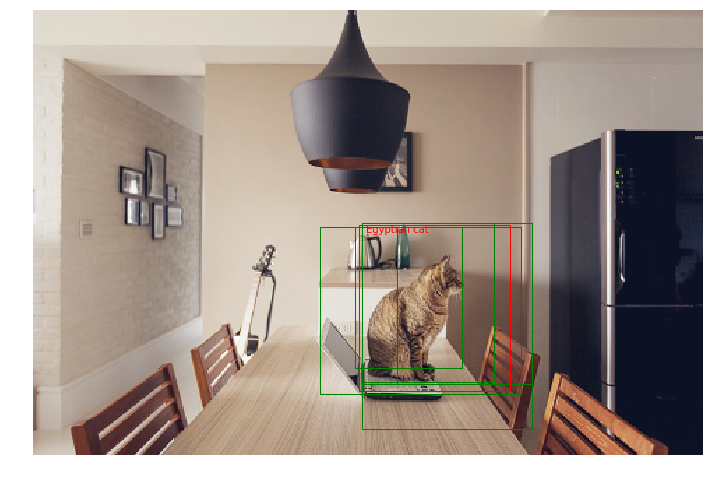

In [9]:
#load a cat image
filename = 'cat'
img = io.imread(filename + '.jpg')

#run selective search on this image and get a bunch of candidate regions of interest
img, candidates = selective_search(img)

#classify each region returned from selective search
net_output = classify_each_region(img, candidates)

#do bounding box analysis
bounding_box = bounding_box_analysis(img, candidates, net_output, cat_inds, filename, 1, True)

Let's repeat the process, this time looking for two baseball players. 

running selective search...
total number of regions found: 1929
number of valid regions found: 1276
transforming image regions...
running forward prop...
running bounding box analysis...


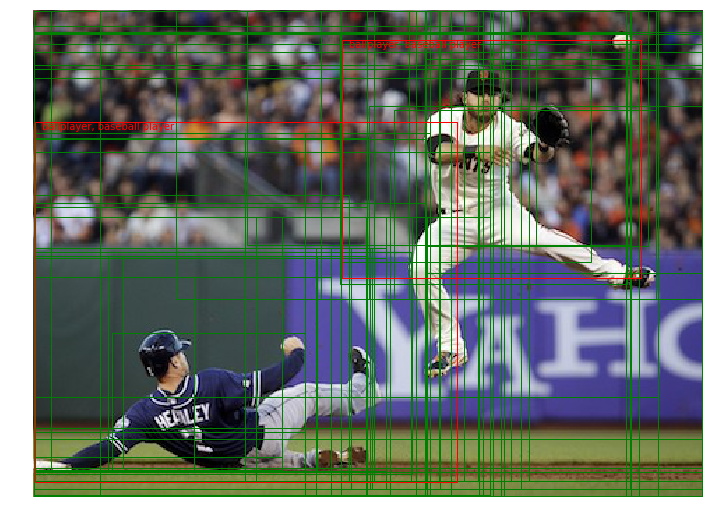

In [10]:
#load a baseball image
filename = 'giants'
img = io.imread(filename + '.jpg')

#run selective search on this image and get a bunch of candidate regions of interest
img, candidates = selective_search(img)

#classify each region returned from selective search
net_output = classify_each_region(img, candidates)

#do bounding box analysis
bounding_box = bounding_box_analysis(img, candidates, net_output, baseball_inds, filename, 2, True)

Ok...this is pretty fun. Let's do one more category, cars (in action).

running selective search...
total number of regions found: 1189
number of valid regions found: 533
transforming image regions...
running forward prop...
running bounding box analysis...


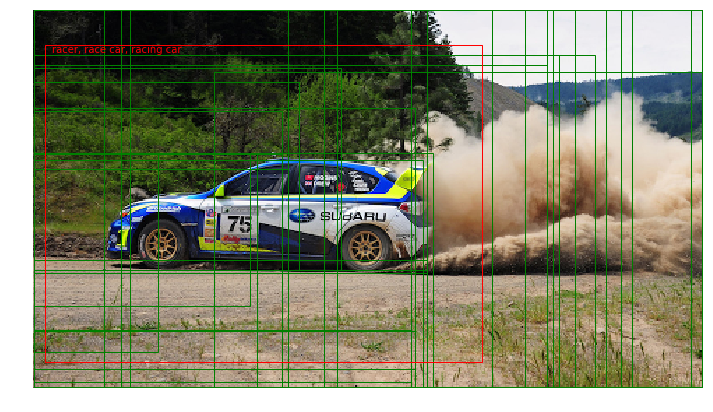

In [11]:
#load a car image
filename = 'subaru'
img = io.imread(filename + '.jpg')

#run selective search on this image and get a bunch of candidate regions of interest
img, candidates = selective_search(img)

#classify each region returned from selective search
net_output = classify_each_region(img, candidates)

#do bounding box analysis
car_inds = np.array([751])
bounding_box = bounding_box_analysis(img, candidates, net_output, car_inds, filename, 1, True)


So there you go, you can quickly identify tons of different objects in an image with minimal development and high accuracy. Of course, each object you try to detect has different physical properties. To make this work for the object you are trying to detect, you may need to make some adjustments. 

Some objects may be more "square-ish", others may be more rectangular. Also, some objects may be further away in the image or closer to the front. In the selective_search function, tweak the values for minimum width and height, and maximum width/height ratio. 

If there are too few positive regions returned by the classifer, openCV may not be able to find a valid bounding box. Try reducing the groupThreshold. Also try increasing epsilon, which yields fewer but larger clusters. 

Lastly, feel free to try a different classifier other than CaffeNet. You can download tons of powerful pretrained models at Caffe's Model Zoo:  
https://github.com/BVLC/caffe/wiki/Model-Zoo

Different models may be more applicable to the object you are trying to detect.